# Read data

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn import linear_model

url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json'
start_from = '2020-02-20'

response = requests.get(url)
my_data = response.json()
df = pd.DataFrame.from_dict(my_data)
df['data'] = [x.split()[0] for x in df['data']]

# save data
pd.DataFrame.to_csv(df,'saved_data.csv')

# start from selected day
d = (df['data'] == start_from).idxmax()
df = df.iloc[d:, :]

df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28,ITA,345,64,409,412,821,233,46,21,888,15695


# Fit linear regression model on logaritmic space

In [2]:
col = 'ricoverati_con_sintomi'

y = df[col].values
y = np.array(y, dtype=int)
y = np.log(y)
y = y.flatten()

y = np.append(y, np.nan) # add one empty value for prediction



t = np.arange(0,len(y),1)
x = t.reshape(-1,1)

test_samples = 1

x_tr = x[0:-test_samples]
y_tr = y[0:-test_samples]
x_te = x[-test_samples:]
y_te = y[-test_samples:]

regressor = linear_model.LinearRegression()  
regressor.fit(x_tr,y_tr)
yhat = regressor.predict(x)

#get standard deviation of y_test
residuals = np.sum((y_tr - regressor.predict(x_tr))**2)
stdev = np.sqrt(residuals)

# Plot data and model prediction 

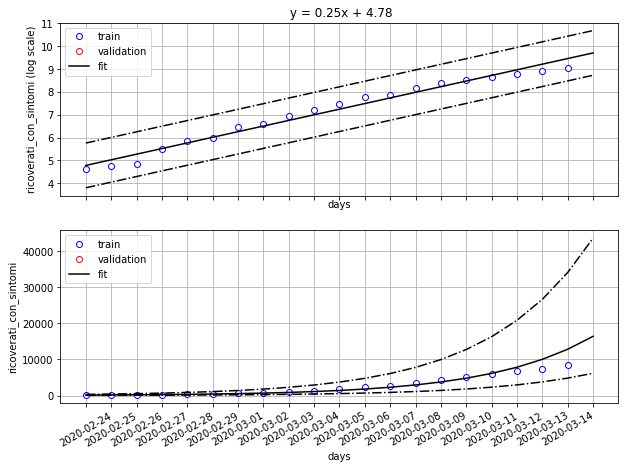

In [3]:
f, ax = plt.subplots(2,1,figsize=[10,7], sharex=True)

ax[0].plot(x_tr, y_tr, 'o',markeredgecolor='b',markerfacecolor='w',label='train')
if test_samples > 0:
    ax[0].plot(x_te, y_te, 'o',markeredgecolor='r',markerfacecolor='w',label='validation')
ax[0].plot(t, yhat, 'k-',label='fit')
ax[0].plot(t, yhat-stdev, 'k-.')
ax[0].plot(t, yhat+stdev, 'k-.')
ax[0].set_ylabel(F'{col} (log scale)')

ax[1].plot(x_tr, np.exp(y_tr), 'o',markeredgecolor='b',markerfacecolor='w',label='train')
if test_samples > 0:
    ax[1].plot(x_te, np.exp(y_te), 'o',markeredgecolor='r',markerfacecolor='w',label='validation')
ax[1].plot(t, np.exp(yhat), 'k-',label='fit')
ax[1].plot(t, np.exp(yhat+stdev), 'k-.')
ax[1].plot(t, np.exp(yhat-stdev), 'k-.')
ax[1].set_ylabel(col)

for a in ax:
    a.set_xticks(t)
    a.set_xlabel('days')
    a.set_xticks(t)
    a.set_xticklabels(df['data'])
    a.grid(b=True)
    a.legend()
    for tick in a.get_xticklabels():
        tick.set_rotation(30)

m = regressor.coef_[0]
q = regressor.intercept_
ax[0].set_title(F' y = {m:.2f}x + {q:.2f}');

plt.savefig('model_prediction.png')

# Print prediction 

In [4]:
yesterday_value = np.exp(yhat[-2])
today_prediction = np.exp(yhat[-1])
today_prediction_lb = np.exp(yhat[-1] - stdev)
today_prediction_ub = np.exp(yhat[-1] + stdev)
today_confidence  = (today_prediction_ub - today_prediction_lb)/2

print(F'Prediction for today: {today_prediction:.0f} +- {today_confidence:.0f}')

Prediction for today: 16396 +- 18720
